## Setup

In [54]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import pandas as pd
import numpy as np
import os

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot the figures
import matplotlib as mlp 
import matplotlib.pyplot as plt
mlp.rc('axes', labelsize=14)
mlp.rc('xtick', labelsize=12)
mlp.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "../"
IMAGES_PATH = "images"
os.makedirs(IMAGES_PATH, exist_ok=True)

# Function to save the figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, figure=None):
    path = os.path.join(IMAGES_PATH, (fig_id + "." + fig_extension))
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()

    if figure is None:
        plt.savefig(path, format=fig_extension, dpi=resolution)
    else:
        figure.savefig(path, format=fig_extension, dpi=resolution)


## Get the  data

In [55]:
DATASETS_PATH = os.path.join(PROJECT_ROOT_DIR, 'datasets')
os.makedirs(DATASETS_PATH, exist_ok=True)

DATASET_NAME = 'dados 2-4.txt'

# columns names for the dataset
columns=['Distance','RSSI']

def load_data(data_path = DATASETS_PATH, dataset_name= DATASET_NAME, columns_names=columns):
    txt_path = os.path.join(data_path, dataset_name)
    return pd.read_table(txt_path, names=columns)

# read the dataset
data_2_4_Ghz = load_data(data_path=DATASETS_PATH, dataset_name=DATASET_NAME, columns_names=columns)
data_2_4_Ghz.head()


,Distance,RSSI
0,1,-21.0
1,2,-30.0
2,3,-29.0
3,4,-33.0
4,5,-32.0


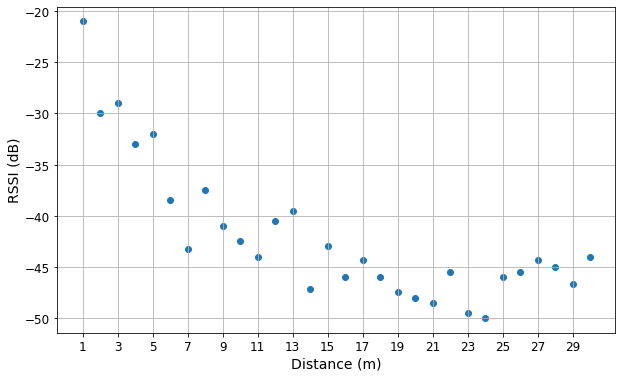

In [56]:
# Show the RSSI behavior in function of the distance
plt.figure(figsize=(10,6))
plt.scatter(data_2_4_Ghz['Distance'], data_2_4_Ghz['RSSI'], label='2.4 GHz')
plt.ylabel('RSSI (dB)')
plt.xlabel('Distance (m)')
plt.xticks(np.arange(1,30,2))
plt.grid()
plt.show()

## Split the data

In [57]:
# Split the data in 3 distances (near, medium, far)
near_data = data_2_4_Ghz[:10]
medium_data = data_2_4_Ghz[10:20]
far_data = data_2_4_Ghz[20:30]

## Optimized Path Loss Equation

In [58]:
# Function to calculate the RSSI using the Optimized Path Loss Equation
def calculate_rssi_with_optimized_path_loss_function(frequency, d):

    # Transmit power
    Pt = 10 * np.log10(250) + 5 + 1
    # Reference distance
    d0 = 1

    # Free-space path loss model
    Ao = 32.44+20*np.log10(d0/1000)+20*np.log10(frequency)

    # Optimized coefficients
    n = 1.7143
    k = 13.3156

    # Optimized Path Loss
    L = Ao + 10*n*np.log10(d/d0) + k

    # Received Power According to the Optimized Path Loss
    Pr = Pt - L
    
    return Pr

## Load the Trained Models

In [59]:
import joblib

# Loads the trained models
lin_reg = joblib.load('models/lin_reg.pkl')
tree_reg_best = joblib.load('models/tree_reg_best.pkl')
forest_reg_best = joblib.load('models/forest_reg_best.pkl')

## Analyzing the Metrics in the Split datas

In [60]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

### Function to evaluate the models

In [61]:
# Plot the R2

def plot_r2(y_test, model_prediction, model_name, color='blue'):
    
    # Values of the RSSI to create the line of the R2=1 which is the ideal value
    rssi_values = np.linspace(-55, -20, 30)
    
    figure = plt.figure(figsize=(10,6))
    plt.scatter(y_test, model_prediction, marker='o', s=30, color=color, label=model_name)
    plt.plot(rssi_values, rssi_values, color='black', linestyle='--', label=r'$R^2=1$ (Caso ideal)')
    plt.xlabel('RSSI real', fontsize=15)
    plt.ylabel('RSSI previsto', fontsize=15)
    plt.legend(loc='best', fontsize=13)
    plt.xlim(-55, -20)
    plt.ylim(-55, -20)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.grid()
    plt.show()

    return figure

In [62]:
# Function to save the metrics of the models and path loss optimized equation in the test set
def save_metrics(lin_reg_rmse, lin_reg_mae, lin_reg_r2,
                            tree_reg_rmse, tree_reg_mae, tree_reg_r2,
                            forest_reg_rmse, forest_reg_mae, forest_reg_r2,
                            path_loss_opt_rmse, path_loss_opt_mae, path_loss_opt_r2,
                            filename='models_metrics_in_test_set.xlsx'):
    
    # Creates the tables folder
    os.makedirs('tables', exist_ok=True)

    METRICS_PATH = os.path.join('tables', filename)
    
    # Creates a dictionary with the metrics
    data = {
        'Model': ['Linear', 'Decision Tree', 'Random Forest','Optimized Equation'],
        'RMSE': [lin_reg_rmse, tree_reg_rmse, forest_reg_rmse, path_loss_opt_rmse],
        'MAE': [lin_reg_mae, tree_reg_mae, forest_reg_mae, path_loss_opt_mae],
        'R2': [lin_reg_r2, tree_reg_r2, forest_reg_r2, path_loss_opt_r2]
    }

    # Creates a dataframe
    df_metrics = pd.DataFrame(data)

    # Saves the dataframe in a excel file
    df_metrics.to_excel(METRICS_PATH, index=False)

    return df_metrics

In [79]:
# Function to evaluate the models and to save the metrics and figures
def evaluate_models(frequency, X_test, y_test, lin_reg_best, tree_reg_best, forest_reg_best, distance, 
                    calculate_rssi_with_optimized_path_loss_function, plot_r2, save_metrics, save_fig):
    
    # Calculates the RSSI using the optimized path loss equation
    path_loss_opt_prediction = calculate_rssi_with_optimized_path_loss_function(frequency, X_test)

    # Predict RSSI in the given distance using the linear model
    lin_reg_prediction = lin_reg_best.predict(X_test)

    # Predict RSSI in the given distance using the tree model
    tree_reg_prediction = tree_reg_best.predict(X_test)

    # Predict RSSI in the given distance using the random forest model
    forest_reg_prediction = forest_reg_best.predict(X_test)

    # Prints and metrics for Optimized Path Loss Equation
    print(f'\n{"-"*10} Optimized Path Loss Equation Metrics - {distance} {"-"*10}')
    path_loss_opt_rmse = np.sqrt(root_mean_squared_error(y_test, path_loss_opt_prediction))
    path_loss_opt_mae = mean_absolute_error(y_test, path_loss_opt_prediction)
    path_loss_opt_r2 = r2_score(y_test, path_loss_opt_prediction)

    print(f'RMSE (Path Loss Optimized): {path_loss_opt_rmse}')
    print(f'MAE (Path Loss Optimized): {path_loss_opt_mae}')
    print(f'R2 (Path Loss Optimized): {path_loss_opt_r2}')

    # Prints and metrics for Linear Regression
    print(f'\n{"-"*10} Linear Regression Metrics - {distance} {"-"*10}')
    lin_reg_rmse = np.sqrt(root_mean_squared_error(y_test, lin_reg_prediction))
    lin_reg_mae = mean_absolute_error(y_test, lin_reg_prediction)
    lin_reg_r2 = r2_score(y_test, lin_reg_prediction)

    print(f'RMSE (Linear Regression): {lin_reg_rmse}')
    print(f'MAE (Linear Regression): {lin_reg_mae}')
    print(f'R2 (Linear Regression): {lin_reg_r2}')

    # Prints and metrics for Decision Tree
    print(f'\n{"-"*10} Decision Tree Metrics - {distance} {"-"*10}')
    tree_reg_rmse = np.sqrt(root_mean_squared_error(y_test, tree_reg_prediction))
    tree_reg_mae = mean_absolute_error(y_test, tree_reg_prediction)
    tree_reg_r2 = r2_score(y_test, tree_reg_prediction)

    print(f'RMSE (Decision Tree): {tree_reg_rmse}')
    print(f'MAE (Decision Tree): {tree_reg_mae}')
    print(f'R2 (Decision Tree): {tree_reg_r2}')

    # Prints and metrics for Random Forest
    print(f'\n{"-"*10} Random Forest Metrics - {distance} {"-"*10}')
    forest_reg_rmse = np.sqrt(root_mean_squared_error(y_test, forest_reg_prediction))
    forest_reg_mae = mean_absolute_error(y_test, forest_reg_prediction)
    forest_reg_r2 = r2_score(y_test, forest_reg_prediction)

    print(f'RMSE (Random Forest): {forest_reg_rmse}')
    print(f'MAE (Random Forest): {forest_reg_mae}')
    print(f'R2 (Random Forest): {forest_reg_r2}')

    # Plot the R2 of the Optimized Path Loss
    fig_r2_path_loss_opt = plot_r2(y_test, path_loss_opt_prediction, f'Equação de Perda de Percurso Otimizada - {distance}', color='purple')
    # Plot the R2 of the Linear Model
    fig_r2_lin_reg = plot_r2(y_test, lin_reg_prediction, f'Regressão Linear - {distance}', color='orange')
    # Plot the R2 of the Decision Tree Model
    fig_r2_tree_reg = plot_r2(y_test, tree_reg_prediction, f'Árvore de Decisão - {distance}', color='blue')
    # Plot the R2 of the Random Forest Model
    fig_r2_forest_reg = plot_r2(y_test, forest_reg_prediction, f'Random Forest - {distance}', color='green')

    # Save the figures
    save_fig(f'2-R2_Linear_Model_{distance}', fig_extension='png', resolution=300, figure=fig_r2_lin_reg)
    save_fig(f'3-R2_Decision_Tree_Model_{distance}', fig_extension='png', resolution=300, figure=fig_r2_tree_reg)
    save_fig(f'4-R2_Random_Forest_Model_{distance}', fig_extension='png', resolution=300, figure=fig_r2_forest_reg)
    save_fig(f'5-R2_Optimized_Path_Loss_{distance}', fig_extension='png', resolution=300, figure=fig_r2_path_loss_opt)

    # Save the metrics
    df_metrics = save_metrics(lin_reg_rmse, lin_reg_mae, lin_reg_r2,
                              tree_reg_rmse, tree_reg_mae, tree_reg_r2,
                              forest_reg_rmse, forest_reg_mae, forest_reg_r2,
                              path_loss_opt_rmse, path_loss_opt_mae, path_loss_opt_r2,
                              filename=f'models_metrics_in_test_set_{distance}.xlsx')

    return df_metrics


### Near Distance

In [77]:
# Creates the feature and labels for the near distance datas
X_near = near_data.drop(['RSSI'],axis=1)
y_near = near_data['RSSI']


---------- Optimized Path Loss Equation Metrics - near ----------
RMSE (Path Loss Optimized): 1.599927446011578
MAE (Path Loss Optimized): 2.2225019392052503
R2 (Path Loss Optimized): 0.8538407315020138

---------- Linear Regression Metrics - near ----------
RMSE (Linear Regression): 2.2564376591490802
MAE (Linear Regression): 4.177068252326783
R2 (Linear Regression): 0.42174610898593523

---------- Decision Tree Metrics - near ----------
RMSE (Decision Tree): 1.819492048238524
MAE (Decision Tree): 2.3349999999999995
R2 (Decision Tree): 0.7555298414867069

---------- Random Forest Metrics - near ----------
RMSE (Random Forest): 1.6999976674544741
MAE (Random Forest): 2.14671714912281
R2 (Random Forest): 0.8136975747960313


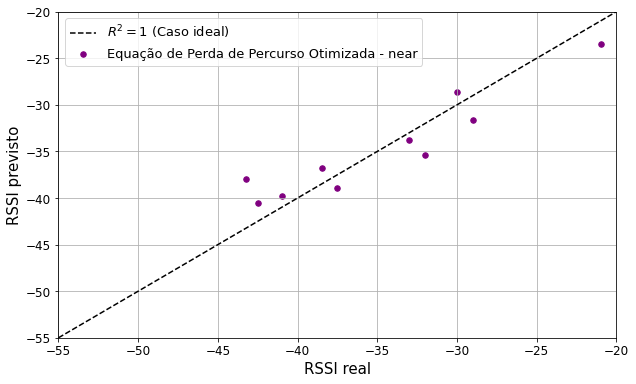

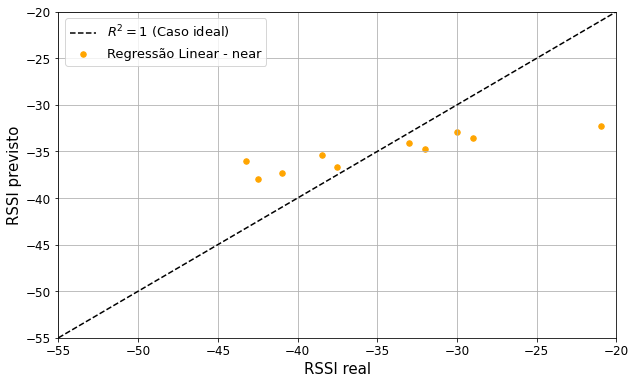

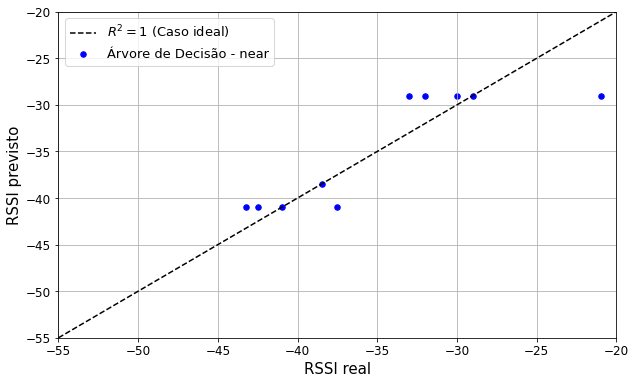

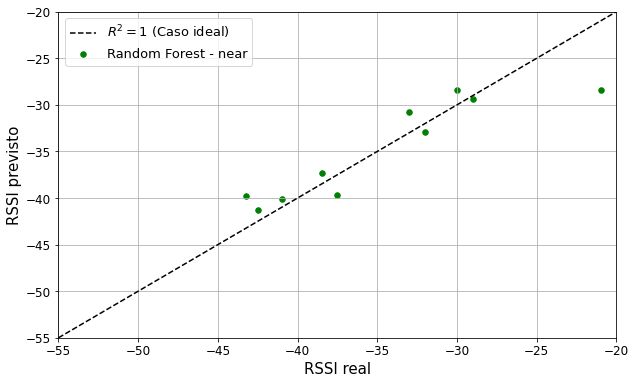

Saving figure 2-R2_Linear_Model_near
Saving figure 3-R2_Decision_Tree_Model_near
Saving figure 4-R2_Random_Forest_Model_near
Saving figure 5-R2_Optimized_Path_Loss_near


<Figure size 432x288 with 0 Axes>

In [81]:
# Distance type
distance = "near"
# Frequency
frequency = 2412
df_metrics_near_distance = evaluate_models(frequency, X_near, y_near, lin_reg, tree_reg_best, forest_reg_best, 'near', calculate_rssi_with_optimized_path_loss_function, plot_r2, save_metrics, save_fig)

### Medium Distance

In [82]:
# Creates the feature and labels for the medium distance datas
X_medium = medium_data.drop(['RSSI'],axis=1)
y_medium = medium_data['RSSI']